# Word2Vec(skip gram)

In [2]:
import tensorflow as tf
import numpy as np
import os

In [3]:
samples = ["철수은 축구를 좋아한다",
          "영희은 축구를 싫어한다",
          "철수은 도서관을 좋아한다",
          "영희은 도서관을 싫어한다",
          "철수은 공부를 좋아한다",
          "영희은 공부를 싫어한다",
          "철수은 축구를 좋아한다 영희은 축구를 싫어한다"]

In [4]:
from tensorflow.keras import preprocessing

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(samples) 
sequences = tokenizer.texts_to_sequences(samples) 

word_to_index = tokenizer.word_index

In [5]:
index_to_word = dict((i, w) for w, i in word_to_index.items())
print(index_to_word)

{1: '철수은', 2: '축구를', 3: '좋아한다', 4: '영희은', 5: '싫어한다', 6: '도서관을', 7: '공부를'}


In [6]:
skip_gram_data = []
print(f'sequences: {sequences}')

for sequence in sequences:
    for i in range(1, len(sequence) - 1):
        context = sequence[i]
        target = sequence[i - 1]
        skip_gram_data.append([target, context])
        target = sequence[i+1]
        skip_gram_data.append([target, context])
        
print(f'skip_gram_data\n{skip_gram_data}')

sequences: [[1, 2, 3], [4, 2, 5], [1, 6, 3], [4, 6, 5], [1, 7, 3], [4, 7, 5], [1, 2, 3, 4, 2, 5]]
skip_gram_data
[[1, 2], [3, 2], [4, 2], [5, 2], [1, 6], [3, 6], [4, 6], [5, 6], [1, 7], [3, 7], [4, 7], [5, 7], [1, 2], [3, 2], [2, 3], [4, 3], [3, 4], [2, 4], [4, 2], [5, 2]]


In [7]:
context = []
target = []
for i in range(len(skip_gram_data)):
    context.append(skip_gram_data[i][0])  # context
    target.append(skip_gram_data[i][1])  # label

In [8]:
num_epochs = 1000
batch_size = 2

In [9]:
def mapping_fn(context, target):
    features = {"context": context}
    return features, target

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((context, target))
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(len(skip_gram_data))

In [12]:
vocab_size = len(word_to_index) + 1
emb_size = 128

In [ ]:
from tensorflow.keras import layers

In [19]:
class SkipGramModel(tf.keras.Model):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipGramModel, self).__init__(name='cbow')
        self.vocab_size = vocab_size
        self.w_1 = tf.Variable(tf.random.uniform([vocab_size, emb_size], -1.0, 1.0))
        self.w_2 = tf.Variable(tf.random.uniform([emb_size, vocab_size], -1.0, 1.0))
    
    def call(self, inputs):
        one_hot_inputs = tf.one_hot(indices=inputs, depth=self.vocab_size)
        one_hot_inputs = tf.squeeze(one_hot_inputs, axis=1)
        
        hidden = tf.matmul(one_hot_inputs, self.w_1)
        
        return tf.matmul(hidden, self.w_2)

In [20]:
model = SkipGramModel(vocab_size = vocab_size, emb_size=emb_size)

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(dataset, epochs=num_epochs)

Epoch 1/100
10/10 [==============================] - 0s 48ms/step - loss: 290.4758 - accuracy: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 299.6429 - accuracy: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 272.6143 - accuracy: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 280.8352 - accuracy: 0.0000e+00
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 295.6141 - accuracy: 0.0000e+00
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 280.6544 - accuracy: 0.0000e+00
Epoch 7/100
10/10 [==============================] - 0s 2ms/step - loss: 296.5876 - accuracy: 0.0000e+00
Epoch 8/100
10/10 [==============================] - 0s 2ms/step - loss: 296.4924 - accuracy: 0.0000e+00
Epoch 9/100
10/10 [==============================] - 0s 2ms/step - loss: 270.7034 - accuracy: 0.0000e+00
Epoch 10/100
10/10 [==============================] - 

10/10 [==============================] - 0s 2ms/step - loss: 296.4924 - accuracy: 0.0000e+00
Epoch 79/100
10/10 [==============================] - 0s 2ms/step - loss: 296.4924 - accuracy: 0.0000e+00
Epoch 80/100
10/10 [==============================] - 0s 2ms/step - loss: 296.4924 - accuracy: 0.0000e+00
Epoch 81/100
10/10 [==============================] - 0s 2ms/step - loss: 280.3743 - accuracy: 0.0000e+00
Epoch 82/100
10/10 [==============================] - 0s 2ms/step - loss: 280.3743 - accuracy: 0.0000e+00
Epoch 83/100
10/10 [==============================] - 0s 2ms/step - loss: 265.8680 - accuracy: 0.0000e+00
Epoch 84/100
10/10 [==============================] - 0s 2ms/step - loss: 264.2562 - accuracy: 0.0000e+00
Epoch 85/100
10/10 [==============================] - 0s 2ms/step - loss: 265.8680 - accuracy: 0.0000e+00
Epoch 86/100
10/10 [==============================] - 0s 2ms/step - loss: 270.7034 - accuracy: 0.0000e+00
Epoch 87/100
10/10 [==============================] - 0s 2m

In [21]:
embdding_matrix = model.w_1.numpy() 

In [22]:
embdding_matrix

array([[-0.6912582 ,  0.43435812, -0.44038272, ...,  0.46941924,
         0.40123987, -0.00427985],
       [-0.24406788, -0.7129404 , -0.7997825 , ..., -0.44956037,
         0.4926431 ,  0.1440285 ],
       [-0.88637483, -0.86287004,  0.4916472 , ..., -0.8424729 ,
         0.5105869 ,  0.8212828 ],
       ...,
       [ 0.29469165,  0.11007055,  0.07615098, ...,  0.00641593,
         1.0091776 , -0.7910029 ],
       [-0.93810487,  0.3539021 , -0.25642705, ...,  0.8513112 ,
         0.58624816, -0.7588825 ],
       [-0.68381596,  0.78850317, -0.91596437, ..., -0.46613836,
         0.78015995,  0.3249693 ]], dtype=float32)

### 임베딩 그림 그리기

In [18]:
%matplotlib inline  

import matplotlib.pyplot as plt  

In [19]:
from sklearn.manifold import TSNE

In [21]:
import matplotlib.font_manager as fm  

In [22]:
font_path = '/content/gdrive/My Drive/asset/font/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=12)

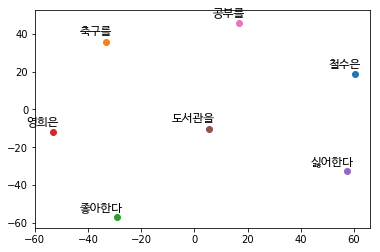

In [23]:
model = TSNE(learning_rate=100)
transformed = model.fit_transform(embdding_matrix)

xs = transformed[:,0]
ys = transformed[:,1]

for i, offset in enumerate(transformed[1:]):
    x, y = offset
    plt.scatter(x, y)
    plt.annotate(index_to_word[i+1], xy=(x, y), xytext=(6, 4),
                 textcoords='offset points', ha='right', va='bottom', fontproperties=fontprop)

plt.show()